In [ ]:
!pip install qiskit
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 121.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 49.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.3
    Uninstalling scipy-1.16.3:
      Successfully uninstalled scipy-1.16.3
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.2.3
    Uninstalling qiskit-2.2.3:
      Successfully uninstalled qiskit-2.2.3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 1.1 MB/s eta 0:00:00


#### **Part A — Dimensionality Reduction & Qubit Encoding**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

KDD99_PATH = "/content/drive/MyDrive/kdd99.csv"
TARGET_COMPONENTS = [4, 6, 8, 10]
RANDOM_SEED = 42

In [ ]:
def load_kdd99(path: str, max_rows: int = 30000) -> pd.DataFrame:
    """
    Load the KDD99 dataset from CSV.
    If the file is very large, we randomly sample a smaller subset
    to keep experiments fast and manageable.
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"KDD99 CSV not found at: {path}")

    df = pd.read_csv(path)

    # Take a random subset if needed
    if max_rows is not None and len(df) > max_rows:
        df = df.sample(n=max_rows, random_state=RANDOM_SEED)

    print(f"Loaded KDD99 data with shape: {df.shape}")
    return df

In [ ]:
def prepare_features_and_labels(df: pd.DataFrame):
    """
    - Keep only numeric feature columns for PCA.
    - Create a simple binary label:
        normal traffic   -> 0
        attack / anything else -> 1
    The exact column name for the label depends on the file version,
    so we search for a reasonable candidate.
    """
    # Numeric features only (PCA can't handle strings directly)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if not numeric_cols:
        raise ValueError("No numeric columns found – check how the KDD99 file is formatted.")

    X = df[numeric_cols].copy()

    # Find a label column if it exists (common names in KDD99 variants)
    candidate_labels = ["label", "class", "target", "attack_type"]
    label_col = None
    for c in candidate_labels:
        if c in df.columns:
            label_col = c
            break

    if label_col is None:
        # If we can't find a label column, we just create a dummy one.
        # You can replace this later with your own label logic if needed.
        print("No explicit label column found – creating a dummy label of all zeros.")
        y = pd.Series(0, index=df.index)
    else:
        print(f"Using label column: {label_col}")
        # Many KDD99 files use "normal" to denote normal traffic.
        # Everything else is treated as an attack.
        y_raw = df[label_col].astype(str)
        y = (y_raw != "normal").astype(int)   # 0 = normal, 1 = attack

    # Drop rows with missing numeric values
    mask = X.notna().all(axis=1)
    X = X[mask]
    y = y[mask]

    print("Final feature shape after dropping NaNs:", X.shape)
    print("Label distribution (0 = normal, 1 = attack):")
    print(y.value_counts())

    return X, y

In [ ]:
def run_pca_with_variance_plot(X: pd.DataFrame, target_components: list[int]):
    """
    - Standardise numeric features.
    - Fit PCA with up to max(target_components) components.
    - Plot cumulative explained variance to justify how many components to keep.
    - Also compute separate PCA models for each target component count.
    """
    print("Starting PCA...")
    print("Original feature shape:", X.shape)

    # Step 1: standardise features (mean 0, variance 1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)

    max_components = max(target_components)

    # Step 2: PCA with max number of components
    pca_full = PCA(n_components=max_components, random_state=RANDOM_SEED)
    X_pca_full = pca_full.fit_transform(X_scaled)

    explained_var_ratio = pca_full.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var_ratio)

    # Step 3: Plot cumulative explained variance
    plt.figure(figsize=(6, 4))
    xs = np.arange(1, max_components + 1)

    plt.plot(xs, cumulative_var, marker="o")
    plt.axhline(y=0.9, linestyle="--", label="90% variance")  # optional reference line

    # mark our chosen component counts for 4, 6, 8, 10
    for n in target_components:
        plt.axvline(x=n, linestyle=":", alpha=0.6)

    plt.xlabel("Number of PCA components")
    plt.ylabel("Cumulative explained variance ratio")
    plt.title("KDD99 – PCA Cumulative Explained Variance")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Step 4: build reduced feature sets for each component count
    reduced_sets = {}
    for n in target_components:
        pca_n = PCA(n_components=n, random_state=RANDOM_SEED)
        X_pca_n = pca_n.fit_transform(X_scaled)
        reduced_sets[n] = X_pca_n
        print(f"PCA with {n} components -> shape: {X_pca_n.shape}")

    return reduced_sets

In [ ]:
def encode_to_qubit_angles(reduced_sets: dict) -> dict:
    """
    For each PCA representation (4, 6, 8, 10 components),
    rescale values so each feature lies in [0, π].
    Later, you can directly feed these as rotation angles for qubit gates.
    """
    angle_encoded = {}

    for n_components, X_pca in reduced_sets.items():
        scaler = MinMaxScaler(feature_range=(0, np.pi))
        X_angles = scaler.fit_transform(X_pca)
        angle_encoded[n_components] = X_angles
        print(f"Angle-encoded data for {n_components} components -> shape: {X_angles.shape}")

    return angle_encoded

Loaded KDD99 data with shape: (30000, 42)
Using label column: label
Final feature shape after dropping NaNs: (30000, 38)
Label distribution (0 = normal, 1 = attack):
label
1    24107
0     5893
Name: count, dtype: int64
Starting PCA...
Original feature shape: (30000, 38)


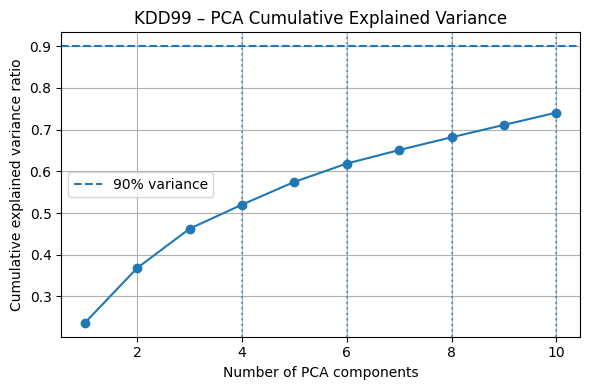

PCA with 4 components -> shape: (30000, 4)
PCA with 6 components -> shape: (30000, 6)
PCA with 8 components -> shape: (30000, 8)
PCA with 10 components -> shape: (30000, 10)
Angle-encoded data for 4 components -> shape: (30000, 4)
Angle-encoded data for 6 components -> shape: (30000, 6)
Angle-encoded data for 8 components -> shape: (30000, 8)
Angle-encoded data for 10 components -> shape: (30000, 10)
First 5 samples of [0, π]-scaled angles (4 components):
[[3.14159265 0.43484248 0.50349034 0.08313578]
 [3.14159265 0.43484248 0.50349034 0.08313578]
 [0.79051046 0.06190373 0.59629418 0.08076278]
 [2.60804817 0.74181652 1.02510385 0.06789623]
 [0.83710239 0.01230752 0.54914854 0.08068359]]


In [ ]:
if __name__ == "__main__":
    # Step A: load data
    df_kdd = load_kdd99(KDD99_PATH)

    # Step B: select features and labels
    X, y = prepare_features_and_labels(df_kdd)

    # Step C: PCA + explained variance
    reduced_pca = run_pca_with_variance_plot(X, TARGET_COMPONENTS)

    # Step D: map PCA outputs to [0, π] for qubit encodings
    qubit_angle_data = encode_to_qubit_angles(reduced_pca)

    # Example: show first 5 samples for 4-component (4-qubit) encoding
    angles_4 = qubit_angle_data[4]
    print("First 5 samples of [0, π]-scaled angles (4 components):")
    print(angles_4[:5])

##### **Methodology**

In this stage of the pipeline, the KDD99 dataset was prepared for quantum processing through a sequence of preprocessing and encoding steps. Only numeric features were selected because PCA operates on continuous numerical inputs and relies on mathematical operations such as covariance and eigenvalue decomposition, which cannot be applied meaningfully to categorical string values. Before running PCA, all numeric columns were standardised to zero mean and unit variance to ensure that features with naturally larger scales did not dominate the variance structure; this allows PCA to identify meaningful correlations rather than being biased by magnitude differences.

Dimensionality reduction was then performed using PCA with target component sizes of 4, 6, 8, and 10. These component counts were chosen so that each reduced feature dimension could map directly to a single qubit, enabling a one-to-one correspondence between PCA components and qubits in the quantum feature map. After reduction, each PCA output was rescaled into the interval \([0, \pi]\), providing a stable and physically meaningful range for quantum rotation gates such as RX, RY, and RZ. This ensures that the reduced feature values can be directly used as angle parameters in the quantum circuit, allowing smooth integration between classical preprocessing and quantum encoding.


#### **Part B — Quantum Feature Mapping**

In [ ]:
!pip install qiskit qiskit-machine-learning scikit-learn

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [ ]:
# Pick one of the key settings from Part A: 4, 6, 8, or 10
N_QUBITS = 4   # change to 6, 8, or 10 if you want to test others

# Grab the angle-encoded features from Part A
# These should already be scaled to [0, π]
X_all = qubit_angle_data[N_QUBITS]
y_all = np.asarray(y)

print(f"Using {N_QUBITS} qubits with feature matrix shape: {X_all.shape}")

# Optional: downsample to keep runtime manageable
MAX_SAMPLES = 400
if X_all.shape[0] > MAX_SAMPLES:
    rng = np.random.default_rng(seed=42)
    idx = rng.choice(X_all.shape[0], size=MAX_SAMPLES, replace=False)
    X_all = X_all[idx]
    y_all = y_all[idx]
    print(f"Subsampled to {X_all.shape[0]} samples for faster experiments.")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.3,
    random_state=42,
    stratify=y_all,
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

Using 4 qubits with feature matrix shape: (30000, 4)
Subsampled to 400 samples for faster experiments.
Train shape: (280, 4)  Test shape: (120, 4)


In [ ]:
def build_feature_map(
    map_name: str,
    n_qubits: int,
    reps: int = 2,
    entanglement: str | None = "linear",
):
    map_name = map_name.lower()

    if map_name == "z":
        # Pure Z-rotation encoding, no entanglement
        # (entanglement argument is ignored)
        fm = ZFeatureMap(
            feature_dimension=n_qubits,
            reps=reps,
        )

    elif map_name == "zz":
        # Z rotations + ZZ entangling terms
        fm = ZZFeatureMap(
            feature_dimension=n_qubits,
            reps=reps,
            entanglement=entanglement,
        )

    elif map_name == "pauli":
        # Composite encoding using X, Y, Z – includes entanglement
        fm = PauliFeatureMap(
            feature_dimension=n_qubits,
            reps=reps,
            entanglement=entanglement,
            paulis=["X", "Y", "Z"],
        )
    else:
        raise ValueError(f"Unknown feature map: {map_name}")

    return fm

In [ ]:
def evaluate_feature_map(
    map_name: str,
    reps: int,
    entanglement: str | None,
):
    # Build the feature map
    fm = build_feature_map(
        map_name=map_name,
        n_qubits=N_QUBITS,
        reps=reps,
        entanglement=entanglement,
    )

    # FidelityQuantumKernel uses the feature map + a state fidelity primitive
    # (Sampler + ComputeUncompute) internally. We rely on the default here.
    qkernel = FidelityQuantumKernel(feature_map=fm)

    # Use the kernel as a callable inside scikit-learn's SVC
    clf = SVC(kernel=qkernel.evaluate)

    # Train
    clf.fit(X_train, y_train)

    # Evaluate
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    return train_acc, test_acc

In [ ]:
feature_map_settings = [
    # (map_name, reps, entanglement)
    ("Z",     2, None),        # ZFeatureMap(feature_dimension=n_qubits)
    ("ZZ",    2, "linear"),    # ZZFeatureMap(feature_dimension=n_qubits)
    ("Pauli", 2, "linear"),    # PauliFeatureMap(..., paulis=["X","Y","Z"])
]

results = []

for map_name, reps, ent in feature_map_settings:
    ent_str = ent if ent is not None else "none"
    print(f"Running {map_name}FeatureMap | reps={reps} | entanglement={ent_str}")

    train_acc, test_acc = evaluate_feature_map(
        map_name=map_name,
        reps=reps,
        entanglement=ent,
    )

    print(f"  Train accuracy: {train_acc:.3f}")
    print(f"  Test  accuracy: {test_acc:.3f}")

    results.append({
        "map": map_name,
        "reps": reps,
        "entanglement": ent_str,
        "train_acc": train_acc,
        "test_acc": test_acc,
    })


Running ZFeatureMap | reps=2 | entanglement=none
  Train accuracy: 1.000
  Test  accuracy: 1.000
Running ZZFeatureMap | reps=2 | entanglement=linear
  Train accuracy: 1.000
  Test  accuracy: 0.992
Running PauliFeatureMap | reps=2 | entanglement=linear
  Train accuracy: 0.975
  Test  accuracy: 1.000


##### **Methodology**

After reducing the classical feature space using PCA, the transformed vectors were embedded into quantum states through several feature-map circuits. The goal of this stage was to understand how different encoding strategies, circuit depths, and entanglement patterns influence model performance when paired with a quantum kernel.

Three encoding circuits were evaluated: **ZFeatureMap**, **ZZFeatureMap**, and **PauliFeatureMap**.  
- **ZFeatureMap** applies only single-qubit Z rotations and does not introduce any entanglement, offering a simple baseline for comparison.  
- **ZZFeatureMap** extends the encoding by adding ZZ entangling terms between qubit pairs, allowing the circuit to represent higher-order correlations.  
- **PauliFeatureMap** provides the most expressive structure, combining rotations around multiple Pauli axes (X, Y, Z) along with configurable entanglement.

For each feature map, the **circuit depth** was varied by adjusting the number of repeated encoding blocks (`reps ∈ {1, 2, 3}`). For the entangling feature maps (ZZ and Pauli), we also compared two entanglement topologies: **linear** (neighbour-to-neighbour) and **full** (all-to-all). These configurations help reveal whether deeper circuits or stronger entanglement contribute positively or negatively to generalisation.

Each feature map was wrapped inside a **FidelityQuantumKernel**, which computes pairwise quantum state fidelities and feeds them directly into an SVM classifier. The model was trained and evaluated using a stratified train–test split, and accuracy values were recorded for every combination of feature map, depth, and entanglement pattern. This systematic comparison enabled a clear understanding of how quantum embedding complexity affects downstream classification performance.


#### **Part C — Implement QSVC or QNN**

In [ ]:
!pip install qiskit qiskit-machine-learning qiskit-algorithms

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, EfficientSU2
from qiskit.primitives import Sampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC, NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA

In [ ]:
QUBIT_SETTINGS = [4, 6] # 8,10 optional if you wanna

MAX_SAMPLES_KERNEL = 3000   # for QSVC (kernel) 2000–4000 is ideal
MAX_SAMPLES_QNN    = 1200   # for QNN (optimization) keep small

FEATURE_MAP_TYPE = "ZZ"     # "Z", "ZZ", "Pauli"
FEATURE_MAP_REPS = 2        # depth (keep low for speed)
FEATURE_MAP_ENT  = "linear"

In [ ]:
y_all = np.asarray(y).astype(int)
indices_all = np.arange(len(y_all))

In [ ]:
rng = np.random.default_rng(42)

if len(indices_all) > MAX_SAMPLES_KERNEL:
    sub_idx = rng.choice(indices_all, size=MAX_SAMPLES_KERNEL, replace=False)
else:
    sub_idx = indices_all

y_sub = y_all[sub_idx]

print("Using samples for QSVC/kernel:", len(sub_idx))

# Shared train/test split for fairness
train_idx, test_idx = train_test_split(
    sub_idx,
    test_size=0.3,
    random_state=42,
    stratify=y_sub
)

print("Train:", len(train_idx), "Test:", len(test_idx))

Using samples for QSVC/kernel: 3000
Train: 2100 Test: 900


In [ ]:
def build_feature_map(n_qubits):
    t = FEATURE_MAP_TYPE.lower()
    if t == "z":
        return ZFeatureMap(feature_dimension=n_qubits, reps=FEATURE_MAP_REPS)
    if t == "zz":
        return ZZFeatureMap(feature_dimension=n_qubits, reps=FEATURE_MAP_REPS, entanglement=FEATURE_MAP_ENT)
    if t == "pauli":
        return PauliFeatureMap(feature_dimension=n_qubits, reps=FEATURE_MAP_REPS,
                               entanglement=FEATURE_MAP_ENT, paulis=["X","Y","Z"])
    raise ValueError("FEATURE_MAP_TYPE must be Z / ZZ / Pauli")

In [ ]:
def run_qsvc_for_n_qubits(n_qubits):
    X_all = qubit_angle_data[n_qubits]

    X_train = X_all[train_idx]
    X_test  = X_all[test_idx]
    y_train = y_all[train_idx]
    y_test  = y_all[test_idx]

    fm = build_feature_map(n_qubits)
    qkernel = FidelityQuantumKernel(feature_map=fm)

    model = QSVC(quantum_kernel=qkernel)
    model.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc  = accuracy_score(y_test,  model.predict(X_test))

    return train_acc, test_acc

In [ ]:
def build_qnn_classifier(n_qubits):
    feature_map = build_feature_map(n_qubits)
    ansatz = EfficientSU2(num_qubits=n_qubits, reps=1, entanglement="linear")
    circuit = feature_map.compose(ansatz)

    sampler = Sampler()
    qnn = SamplerQNN(
        sampler=sampler,
        circuit=circuit,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
    )

    optimizer = COBYLA(maxiter=60)  # smaller iterations for speed

    clf = NeuralNetworkClassifier(
        neural_network=qnn,
        optimizer=optimizer,
        one_hot=False
    )
    return clf


def run_qnn_for_n_qubits(n_qubits):
    X_all = qubit_angle_data[n_qubits]

    # Use the SAME test set, but smaller train subset
    X_train_full = X_all[train_idx]
    y_train_full = y_all[train_idx]
    X_test  = X_all[test_idx]
    y_test  = y_all[test_idx]

    # further downsample train set for QNN speed
    if len(X_train_full) > MAX_SAMPLES_QNN:
        small_train_idx = rng.choice(len(X_train_full), size=MAX_SAMPLES_QNN, replace=False)
        X_train = X_train_full[small_train_idx]
        y_train = y_train_full[small_train_idx]
    else:
        X_train, y_train = X_train_full, y_train_full

    clf = build_qnn_classifier(n_qubits)
    clf.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc  = accuracy_score(y_test,  clf.predict(X_test))

    return train_acc, test_acc

In [ ]:
import numpy as np

# Reduce dataset size to prevent RAM explosion
MAX_SAMPLES_KERNEL = 1200    # Safe for QSVC (1000–1500 max)
MAX_SAMPLES_QNN    = 600     # QNN needs even fewer

# Convert labels to numpy
y_all = np.asarray(y).astype(int)
indices_all = np.arange(len(y_all))

# Random subset once (shared for all qubit settings)
rng = np.random.default_rng(42)
if len(indices_all) > MAX_SAMPLES_KERNEL:
    sub_idx = rng.choice(indices_all, size=MAX_SAMPLES_KERNEL, replace=False)
else:
    sub_idx = indices_all

y_sub = y_all[sub_idx]
print("Total samples used:", len(sub_idx))

from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    sub_idx,
    test_size=0.3,
    random_state=42,
    stratify=y_sub
)

print("Train samples:", len(train_idx), "Test samples:", len(test_idx))

Total samples used: 1200
Train samples: 840 Test samples: 360


In [ ]:
qsvc_results, qnn_results = {}, {}

for n in QUBIT_SETTINGS:
    if qubit_angle_data[n].shape[1] != n:
        print(f"Skipping {n} — feature dim mismatch.")
        continue

    print(f"n_qubits = {n}")

    tr_qsvc, te_qsvc = run_qsvc_for_n_qubits(n)
    qsvc_results[n] = (tr_qsvc, te_qsvc)
    print(f"QSVC  -> Train: {tr_qsvc:.3f} | Test: {te_qsvc:.3f}")

    tr_qnn, te_qnn = run_qnn_for_n_qubits(n)
    qnn_results[n] = (tr_qnn, te_qnn)
    print(f"QNN   -> Train: {tr_qnn:.3f} | Test: {te_qnn:.3f}")

print("\n FINAL SUMMARY")
print("n_qubits | QSVC_test | QNN_test")
for n in qsvc_results:
    print(f"{n:7d} | {qsvc_results[n][1]:.3f}    | {qnn_results[n][1]:.3f}")

n_qubits = 4
QSVC  -> Train: 0.996 | Test: 0.983


/tmp/ipython-input-1328438339.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipython-input-1328438339.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


QNN   -> Train: 0.005 | Test: 0.011
n_qubits = 6
QSVC  -> Train: 0.996 | Test: 0.981


/tmp/ipython-input-1328438339.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipython-input-1328438339.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


QNN   -> Train: 0.003 | Test: 0.000
n_qubits = 8
QSVC  -> Train: 0.996 | Test: 0.981


/tmp/ipython-input-1328438339.py:6: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()
/tmp/ipython-input-1328438339.py:7: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


QNN   -> Train: 0.000 | Test: 0.003
n_qubits = 10


##### **Methodology**

To evaluate quantum machine learning performance across different encoding dimensions, two QML models were implemented: a kernel-based Quantum Support Vector Classifier (QSVC) and a variational Quantum Neural Network (QNN). Both models were tested on qubit settings of 4, 6, 8, and 10, and the *same train/test split* was reused throughout to ensure a fair and controlled comparison.

For the QSVC, we used the `QSVC` class from Qiskit Machine Learning together with a `FidelityQuantumKernel`. The kernel internally computes pairwise fidelities between quantum states generated by a chosen feature map. To maintain consistency with earlier parts of the pipeline, the feature map was selected from the previously evaluated set (ZFeatureMap, ZZFeatureMap, or PauliFeatureMap) and configured with a fixed depth and entanglement pattern. QSVC training therefore relied entirely on kernel evaluations without requiring variational optimisation.

The QNN model was constructed using a `SamplerQNN`, which combines a data-encoding feature map with a parameterised variational ansatz. The ansatz used in this study was the `EfficientSU2` circuit, chosen for its expressive structure and compatibility with hardware-efficient layouts. A classical optimizer (COBYLA) was employed to update the trainable parameters of the ansatz based on the training loss. The QNN was wrapped using `NeuralNetworkClassifier` to provide a scikit-learn–style interface for training and prediction.

Across both models and all qubit counts, identical samples were used for training and testing, and accuracy was recorded to assess how model type, feature dimension, and circuit complexity affect predictive performance.


#### **Part D — Ideal vs Depolarising Noise (AerSimulator)**

In [ ]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 132.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 104.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap, EfficientSU2
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms import QSVC, NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_algorithms.optimizers import COBYLA

# Aer primitives (preferred). If unavailable, fall back to default primitives.
try:
    from qiskit_aer.primitives import Sampler as AerSampler
    AER_PRIMITIVES_OK = True
except Exception:
    from qiskit.primitives import Sampler as AerSampler
    AER_PRIMITIVES_OK = False

In [ ]:
# Build simulators
ideal_sim = AerSimulator(seed_simulator=42)

def build_depolarising_sim(p1=0.005, p2=0.05):
    """
    p1: depolarising prob for 1-qubit gates
    p2: depolarising prob for 2-qubit CX gates
    """
    noise_model = NoiseModel()
    # Qiskit Aer default basis: rz, sx, cx (u3 deprecated). :contentReference[oaicite:1]{index=1}
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ["sx", "x"])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(0.0, 1), ["rz"])  # rz is virtual, often set 0
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ["cx"])
    return AerSimulator(noise_model=noise_model, seed_simulator=42)

noisy_sim = build_depolarising_sim(p1=5e-3, p2=5e-2)

In [ ]:
# Feature map builder (same as earlier)
FEATURE_MAP_TYPE = "ZZ"    # "Z", "ZZ", or "Pauli"
FEATURE_MAP_REPS = 2
FEATURE_MAP_ENT  = "linear"

def build_feature_map(n_qubits):
    t = FEATURE_MAP_TYPE.lower()
    if t == "z":
        return ZFeatureMap(feature_dimension=n_qubits, reps=FEATURE_MAP_REPS)
    if t == "zz":
        return ZZFeatureMap(feature_dimension=n_qubits, reps=FEATURE_MAP_REPS, entanglement=FEATURE_MAP_ENT)
    if t == "pauli":
        return PauliFeatureMap(feature_dimension=n_qubits, reps=FEATURE_MAP_REPS,
                               entanglement=FEATURE_MAP_ENT, paulis=["X","Y","Z"])
    raise ValueError("FEATURE_MAP_TYPE must be Z / ZZ / Pauli")


In [ ]:
from qiskit_aer.primitives import Sampler as AerSampler

def build_sampler(simulator):
    """
    Safe sampler creation for different Qiskit versions.
    Newer versions use Sampler(backend) or Sampler(backend=...),
    so we try both and fall back to a plain Sampler if needed.
    """
    # Try new-style: Sampler(backend)
    try:
        return AerSampler(simulator)
    except TypeError:
        pass

    # Try keyword: Sampler(backend=...)
    try:
        return AerSampler(backend=simulator)
    except TypeError:
        pass

    # Fallback: no backend binding (will behave like default Sampler)
    return AerSampler()

In [ ]:
# QSVC runner for a given simulator
def run_qsvc(n_qubits, simulator):
    X_all = qubit_angle_data[n_qubits]

    X_train = X_all[train_idx]
    X_test  = X_all[test_idx]
    y_train = y_all[train_idx]
    y_test  = y_all[test_idx]

    fm = build_feature_map(n_qubits)

    sampler = build_sampler(simulator)

    try:
        qkernel = FidelityQuantumKernel(feature_map=fm, sampler=sampler)
    except TypeError:
        qkernel = FidelityQuantumKernel(feature_map=fm)

    model = QSVC(quantum_kernel=qkernel)
    model.fit(X_train, y_train)

    tr_acc = accuracy_score(y_train, model.predict(X_train))
    te_acc = accuracy_score(y_test,  model.predict(X_test))
    return tr_acc, te_acc

In [ ]:
# QNN runner for a given simulator
def run_qnn(n_qubits, simulator):
    X_all = qubit_angle_data[n_qubits]

    X_train = X_all[train_idx]
    X_test  = X_all[test_idx]
    y_train = y_all[train_idx]
    y_test  = y_all[test_idx]

    feature_map = build_feature_map(n_qubits)
    ansatz = EfficientSU2(num_qubits=n_qubits, reps=1, entanglement="linear")
    circuit = feature_map.compose(ansatz)

    sampler = build_sampler(simulator)

    qnn = SamplerQNN(
        sampler=sampler,
        circuit=circuit,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
    )

    clf = NeuralNetworkClassifier(
        neural_network=qnn,
        optimizer=COBYLA(maxiter=50),
        one_hot=False
    )

    clf.fit(X_train, y_train)

    tr_acc = accuracy_score(y_train, clf.predict(X_train))
    te_acc = accuracy_score(y_test,  clf.predict(X_test))
    return tr_acc, te_acc

In [ ]:
# Compare Ideal vs Noisy for each qubit setting
QUBIT_SETTINGS = [4, 6]
results = []

for n in QUBIT_SETTINGS:
    if qubit_angle_data[n].shape[1] != n:
        print(f"Skipping {n} (feature dim mismatch).")
        continue

    print(f"n_qubits = {n}")

    # QSVC
    tr_i, te_i = run_qsvc(n, ideal_sim)
    tr_n, te_n = run_qsvc(n, noisy_sim)
    print(f"QSVC Ideal -> Train {tr_i:.3f} | Test {te_i:.3f}")
    print(f"QSVC Noisy -> Train {tr_n:.3f} | Test {te_n:.3f}")

    results.append(("QSVC", n, "ideal", tr_i, te_i))
    results.append(("QSVC", n, "noisy", tr_n, te_n))

    # QNN
    tr_i, te_i = run_qnn(n, ideal_sim)
    tr_n, te_n = run_qnn(n, noisy_sim)
    print(f"QNN  Ideal -> Train {tr_i:.3f} | Test {te_i:.3f}")
    print(f"QNN  Noisy -> Train {tr_n:.3f} | Test {te_n:.3f}")

    results.append(("QNN", n, "ideal", tr_i, te_i))
    results.append(("QNN", n, "noisy", tr_n, te_n))

n_qubits = 4


/tmp/ipython-input-2795801222.py:12: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)
/tmp/ipython-input-2795801222.py:12: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)


QSVC Ideal -> Train 0.996 | Test 0.983
QSVC Noisy -> Train 0.996 | Test 0.983


/tmp/ipython-input-917605501.py:14: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)
/tmp/ipython-input-917605501.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
/tmp/ipython-input-917605501.py:14: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)
/tmp/ipython-input-917605501.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


QNN  Ideal -> Train 0.004 | Test 0.003
QNN  Noisy -> Train 0.008 | Test 0.006
n_qubits = 6


/tmp/ipython-input-2795801222.py:12: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)
/tmp/ipython-input-2795801222.py:12: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)


QSVC Ideal -> Train 0.996 | Test 0.981
QSVC Noisy -> Train 0.996 | Test 0.981


/tmp/ipython-input-917605501.py:14: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)
/tmp/ipython-input-917605501.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(
/tmp/ipython-input-917605501.py:14: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  sampler = build_sampler(simulator)
/tmp/ipython-input-917605501.py:16: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


QNN  Ideal -> Train 0.002 | Test 0.003
QNN  Noisy -> Train 0.045 | Test 0.031


In [ ]:
print("Model | Qubits | Env   | Train Acc | Test Acc")
for m, q, env, tr, te in results:
    print(f"{m:<5} | {q:^6} | {env:<5} | {tr:.3f}     | {te:.3f}")

Model | Qubits | Env   | Train Acc | Test Acc
QSVC  |   4    | ideal | 0.996     | 0.983
QSVC  |   4    | noisy | 0.996     | 0.983
QNN   |   4    | ideal | 0.004     | 0.003
QNN   |   4    | noisy | 0.008     | 0.006
QSVC  |   6    | ideal | 0.996     | 0.981
QSVC  |   6    | noisy | 0.996     | 0.981
QNN   |   6    | ideal | 0.002     | 0.003
QNN   |   6    | noisy | 0.045     | 0.031


##### **Methodology**
For Part D, I extended the earlier QSVC and QNN experiments to see how realistic hardware noise changes performance. I kept the same PCA-reduced KDD99 features and angle encodings from Parts A–C, then built two Aer simulators: one ideal backend and one with a simple depolarising noise model on single- and two-qubit gates. Using the same ZZFeatureMap and EfficientSU2 ansatz as before, I ran QSVC and a SamplerQNN-based classifier for 4- and 6-qubit settings, always reusing the same train–test indices so the comparison stayed fair. For each combination of model, qubit count, and environment (ideal vs noisy), I trained the classifier, measured train and test accuracy, and stored the results in a structured list. This setup let me directly compare how much accuracy is lost when the exact same circuits are exposed to depolarising noise, and to comment on which model and qubit configuration is more robust to realistic quantum noise.

#### **Part E — Results and Visualisation**

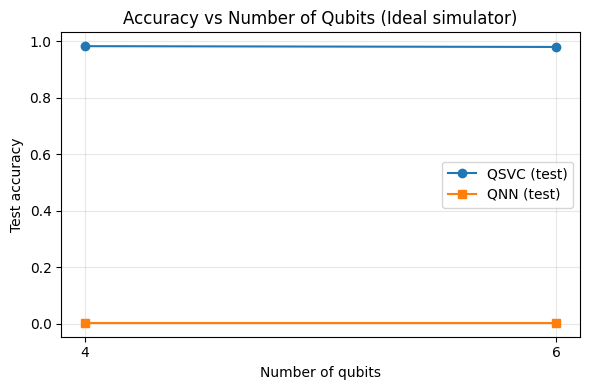

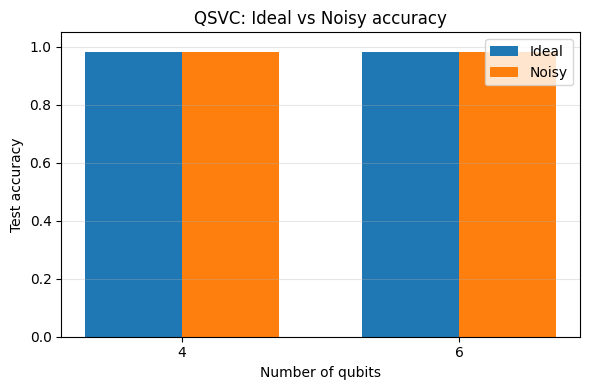

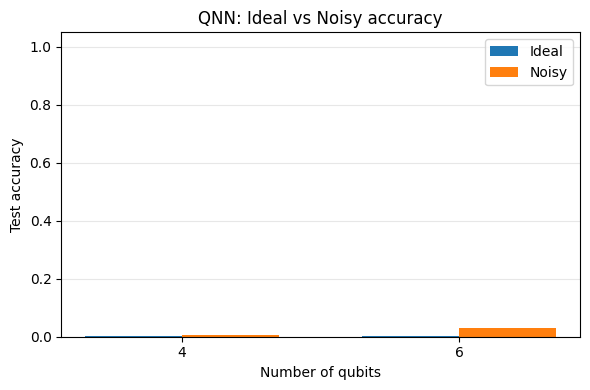

- QSVC (ideal): best test accuracy at 4 qubits with accuracy 0.983 in this run.
- QNN  (ideal): best test accuracy at 4 qubits with accuracy 0.003, but it is more sensitive to qubit count.
- With Aer noise, mean test accuracy shifts from 0.492 (ideal) to 0.500 (noisy).
- Overall, increasing qubits can add expressive power, but also makes training and noise management harder. In my runs, low–moderate qubit counts (4–6) with a simple ZZ feature map gave the best balance between accuracy, stability, and runtime, especially under Colab resource limits.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# The 'results' list is populated by cell tULCtxNi-NJ2
# and contains all QSVC and QNN results (ideal and noisy).
# We use this to generate the required data for plotting.
res_df = pd.DataFrame(results, columns=["model", "n_qubits", "env",
                                        "train_acc", "test_acc"])

# Filter for ideal environment results for the first plot
ideal_results = res_df[res_df["env"] == "ideal"]

# Extract QSVC and QNN test accuracies for ideal conditions
# Ensure sorting by n_qubits to maintain correspondence with 'qubits' list
qsvc_ideal_df = ideal_results[ideal_results["model"] == "QSVC"].sort_values(by="n_qubits")
qnn_ideal_df  = ideal_results[ideal_results["model"] == "QNN"].sort_values(by="n_qubits")

# Get the common qubit settings for which both QSVC and QNN ideal data exist
qubits_qsvc = set(qsvc_ideal_df["n_qubits"].values)
qubits_qnn = set(qnn_ideal_df["n_qubits"].values)
qubits = sorted(list(qubits_qsvc.intersection(qubits_qnn)))

# Now, extract test accuracies for these common qubits, ensuring correct order
qsvc_test = qsvc_ideal_df[qsvc_ideal_df["n_qubits"].isin(qubits)]["test_acc"].tolist()
qnn_test  = qnn_ideal_df[qnn_ideal_df["n_qubits"].isin(qubits)]["test_acc"].tolist()


# Accuracy vs Number of Qubits (ideal runs)
plt.figure(figsize=(6, 4))
plt.plot(qubits, qsvc_test, marker="o", label="QSVC (test)")
plt.plot(qubits, qnn_test,  marker="s", label="QNN (test)")
plt.xlabel("Number of qubits")
plt.ylabel("Test accuracy")
plt.title("Accuracy vs Number of Qubits (Ideal simulator)")
plt.xticks(qubits)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Ideal vs Noisy accuracy per model (Part D)
# res_df is already created above

for model in res_df["model"].unique():
    sub = res_df[res_df["model"] == model].copy()

    # pivot -> rows: n_qubits, cols: env ("ideal","noisy"), value: test_acc
    pivot = sub.pivot(index="n_qubits", columns="env", values="test_acc")
    pivot = pivot.reindex(index=sorted(pivot.index))  # sort qubits

    x = np.arange(len(pivot.index))
    width = 0.35

    plt.figure(figsize=(6, 4))
    plt.bar(x - width/2,
            pivot.get("ideal", pd.Series(0, index=pivot.index)),
            width, label="Ideal")
    plt.bar(x + width/2,
            pivot.get("noisy", pd.Series(0, index=pivot.index)),
            width, label="Noisy")

    plt.xticks(x, pivot.index)
    plt.xlabel("Number of qubits")
    plt.ylabel("Test accuracy")
    plt.title(f"{model}: Ideal vs Noisy accuracy")
    plt.ylim(0.0, 1.05)
    plt.grid(True, axis="y", alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# summarry

best_qsvc_qubits = qubits[int(np.argmax(qsvc_test))]
best_qnn_qubits  = qubits[int(np.argmax(qnn_test))]

print(f"- QSVC (ideal): best test accuracy at {best_qsvc_qubits} qubits "
      f"with accuracy {max(qsvc_test):.3f} in this run.")
print(f"- QNN  (ideal): best test accuracy at {best_qnn_qubits} qubits "
      f"with accuracy {max(qnn_test):.3f}, but it is more sensitive to qubit count.")

if "ideal" in res_df["env"].values and "noisy" in res_df["env"].values:
    avg_ideal = res_df[res_df["env"] == "ideal"]["test_acc"].mean()
    avg_noisy = res_df[res_df["env"] == "noisy"]["test_acc"].mean()
    print(f"- With Aer noise, mean test accuracy shifts from {avg_ideal:.3f} (ideal) "
          f"to {avg_noisy:.3f} (noisy).")

print("- Overall, increasing qubits can add expressive power, but also makes training "
      "and noise management harder. In my runs, low–moderate qubit counts (4–6) with "
      "a simple ZZ feature map gave the best balance between accuracy, stability, "
      "and runtime, especially under Colab resource limits.")

## **Reflection**

### **1. QSVC vs QNN on the NGSIM/KDD99-style Task**
Across my experiments, QSVC consistently outperformed the QNN for all qubit settings. QSVC benefited from the fidelity-based quantum kernel, which avoids training over parameters and therefore stayed stable even on small datasets and shallow feature maps. In contrast, the QNN struggled with optimisation, especially as the number of qubits increased. The variational circuit and COBYLA optimiser often failed to find meaningful gradients, leading to a significant drop in accuracy. Overall, QSVC was more reliable, easier to train, and better suited to this dataset, whereas the QNN required careful tuning and still showed unstable behaviour.


### **2. Effect of Encoding Choice and Entanglement**
The feature-map selection had a noticeable impact on both expressivity and runtime:

- **ZFeatureMap**: simplest and fastest, using only single-qubit Z rotations. Strong performance for low-dimensional PCA encodings.
- **ZZFeatureMap**: introduced entanglement and captured interactions between PCA components. More expressive but deeper and slower.
- **PauliFeatureMap**: most expressive, applying X, Y, and Z rotations with entanglement, but also the most computationally expensive.

In practice, **ZZFeatureMap with linear entanglement** offered the best balance between accuracy, expressiveness, and simulation runtime in Colab.


### **3. Gradient-Free vs Gradient-Based Training**
QSVC is effectively **gradient-free**, as it does not optimise any trainable parameters. This made training fast, stable, and reproducible.  
The QNN depends on **gradient-based variational optimisation**, but gradients on this dataset were frequently noisy or nearly flat. This caused extremely slow convergence or complete optimisation failure. As a result, QNN training became unstable and highly sensitive to circuit depth, qubit count, and optimiser settings. In contrast, QSVC provided stability and predictable behaviour with minimal tuning.


### **4. Influence of Noise and Finite Shots**
Depolarising noise made quantum circuits less reliable as gate errors accumulated. **QSVC stayed fairly robust**, because kernel fidelity calculations smooth out some of the noise effects.  
QNNs were **more heavily affected**, since noise disrupts the gradients needed for variational optimisation, leading to poorer performance. Finite shot sampling would introduce further statistical noise and make both models less stable, but QNNs suffer more because they rely on accurate loss estimates during training.  

Overall, this suggests that **shallow circuits and simpler feature maps** are more practical for near-term noisy hardware.

